# Quick Demo of Global Histogram Transfer

This iPython Notebook gives a quick demonstration of our system, and requires a working installation of Caffe. Directory ```./caffe_files``` should be appended to ```PYTHONPATH``` in your system.

In [6]:
import caffe
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from data import colorize_image as CI
from skimage import color
from data import lab_gamut as lab

%matplotlib inline

## Select images

Images used in our camera ready paper are in directory ```./test_imgs```

In [7]:
# image to colorize
img_path = './test_imgs/bird_gray.jpg'

# color histogram to use
ref_path = './test_imgs/global_ref_bird/ILSVRC2012_val_00002383.JPEG'

## Load colorization network

In [8]:
gpu_id = 0 # gpu to use
Xd = 256

# Colorization network
cid = CI.ColorizeImageCaffeGlobDist(Xd)
cid.prep_net(gpu_id,prototxt_path='./models/global_model/deploy_nodist.prototxt',\
            caffemodel_path='./models/global_model/global_model.caffemodel')

# Global distribution network - extracts global color statistics from an image
gt_glob_net = caffe.Net('./models/global_model/global_stats.prototxt',\
                       './models/global_model/dummy.caffemodel', caffe.TEST)

ColorizeImageCaffe instantiated
gpu_id = 0, net_path = ./models/global_model/deploy_nodist.prototxt, model_path = ./models/global_model/global_model.caffemodel


## Colorization in automatic mode (with no reference histogram)

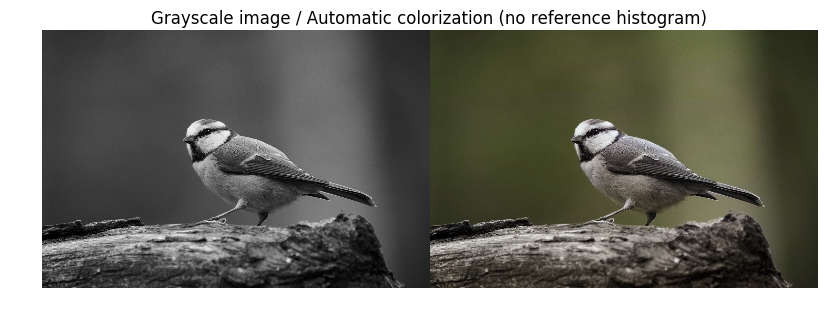

In [9]:
# Load image
cid.load_image(img_path)

# Dummy variables
input_ab = np.zeros((2,Xd,Xd))
input_mask = np.zeros((1,Xd,Xd))

# Colorization without global histogram
img_pred = cid.net_forward(input_ab,input_mask);
img_pred_auto_fullres = cid.get_img_fullres()

# Gray image
img_gray_fullres = cid.get_img_gray_fullres()

# Plot result
plt.figure(figsize=(10,4))
plt.imshow(np.concatenate((img_gray_fullres,img_pred_auto_fullres),axis=1));
plt.title('Grayscale image / Automatic colorization (no reference histogram)')
plt.axis('off');

## Colorization with reference global histogram

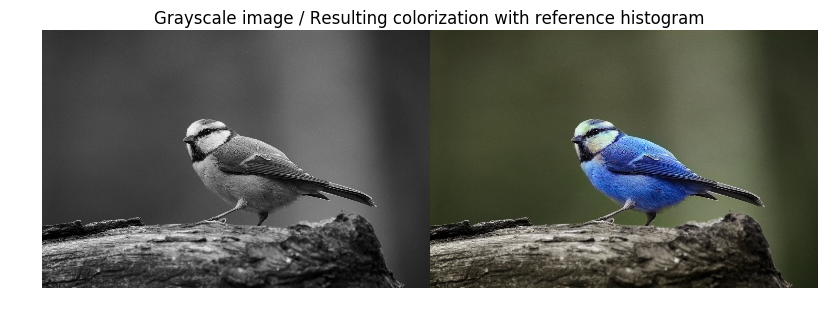

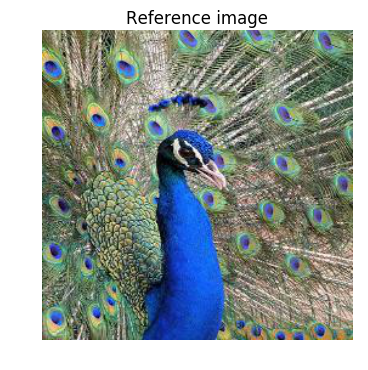

In [11]:
# Colorization with reference global histogram
def get_global_histogram(img_path):
    ref_img_fullres = caffe.io.load_image(ref_path)
    img_glob_dist = (255*caffe.io.resize_image(ref_img_fullres,(Xd,Xd))).astype('uint8') # load image
    gt_glob_net.blobs['img_bgr'].data[...] = img_glob_dist[:,:,::-1].transpose((2,0,1)) # put into 
    gt_glob_net.forward();
    glob_dist_in = gt_glob_net.blobs['gt_glob_ab_313_drop'].data[0,:-1,0,0].copy()
    return (glob_dist_in,ref_img_fullres)

(glob_dist_ref,ref_img_fullres) = get_global_histogram(ref_path)
img_pred = cid.net_forward(input_ab,input_mask,glob_dist_ref);
img_pred_withref_fullres = cid.get_img_fullres()

plt.figure(figsize=(10,4))
plt.imshow(np.concatenate((img_gray_fullres,img_pred_withref_fullres),axis=1));
plt.title('Grayscale image / Resulting colorization with reference histogram')
plt.axis('off');

plt.figure(figsize=(4,4))
plt.imshow(ref_img_fullres);
plt.title('Reference image');
plt.axis('off');